In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_color_codes('pastel')

In [2]:
needed_leads = '''HOTLEAD-Calendly - Corp Email Lead
HOTLEAD-Calendly - Facebook
HOTLEAD-Calendly - Google for HL
HOTLEAD-Calendly - LinkedIn
HOTLEAD-Calendly - nan
HOTLEAD-Calendly - ORG
HOTLEAD-email - nan
HOTLEAD-email - ORG
HOTLEAD-LinkedIn-LGF - LinkedIn
HOTLEAD-LMWebForm - Bing for Cases
HOTLEAD-LMWebForm - Bing for HL
HOTLEAD-LMWebForm - Corp Email Lead
HOTLEAD-LMWebForm - Google for Cases
HOTLEAD-LMWebForm - Google for HL
HOTLEAD-LMWebForm - LinkedIn
HOTLEAD-LMWebForm - nan
HOTLEAD-LMWebForm - ORG
HOTLEAD-LMWebForm - Other for HL
HOTLEAD-LMWebForm - Reddit
HOTLEAD-other - Facebook
HOTLEAD-other - Facebook Messenger
HOTLEAD-other - Instagram
HOTLEAD-other - nan
HOTLEAD-phone - nan
HOTLEAD-phone - ORG
HOTLEAD-phone - Voicemail
Corp Email Lead - Corp Email Lead
Corp Email Lead - nan
Corp Email Lead - Newsletter Lead
Social Media Engagement - Facebook
Social Media Engagement - LinkedIn'''

needed_leads = needed_leads.split('\n')

In [3]:
oppty = pd.read_csv('raw\sf_export_oppty.csv', encoding='latin-1')
oppty.dropna(subset=['Opportunity ID'], inplace= True)

needed_col = ['Created Date', 'Case Review Set', 'Case Review Completed','Enrollment Meeting Set', 'Order Date', 'Opportunity Disposition Date', 'Enrollment Meeting Completed','Enrollment Meeting Date and Time', 'Close Date']

for col in needed_col:
    oppty[col] = pd.to_datetime(oppty[col])

oppty['Lead Source with Type'] = oppty.apply(lambda x: str(x['Lead Source']) + ' - ' + str(x['Lead Source Type']), axis= 1)
oppty = oppty[oppty['Lead Source with Type'].isin(needed_leads)]
oppty.rename(columns={"Billing State/Province":'State'}, inplace= True)
oppty['State'] = oppty['State'].str.upper()
needed_state = [value for value in oppty['State'] if len(str(value)) == 2]
oppty = oppty[oppty['State'].isin(needed_state)]
oppty.reset_index(drop=True, inplace= True)    

C:\Users\USER\AppData\Local\Temp\ipykernel_23312\426216638.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  oppty = pd.read_csv('raw\sf_export_oppty.csv', encoding='latin-1')


#### Checking the volume of oppty without tiering

In [4]:
oppty['No Tiering'] = oppty['Lead Tier'].isna()
oppty['w Tiering'] = ~oppty['Lead Tier'].isna()

In [5]:
oppty['Lead Tier'].value_counts()

Tier 2    6711
Tier 1    5933
Tier 4    4291
Tier 3    1140
Name: Lead Tier, dtype: int64

In [6]:
pv = oppty.loc[oppty['Created Date'] > pd.to_datetime('2022-08-01')].pivot_table(index=oppty['Created Date'].dt.to_period('W'), values =['w Tiering','No Tiering'], aggfunc='sum')

In [7]:
pv['No Tier Rate'] = pv['No Tiering'] / (pv['No Tiering'] + pv['w Tiering'])

In [8]:
pv.reset_index(inplace= True)

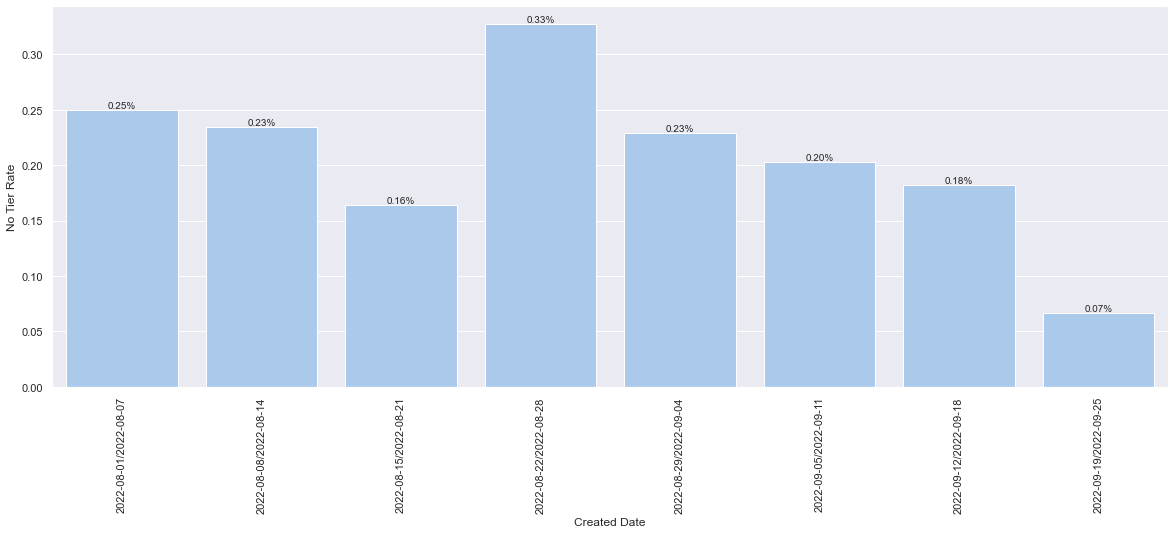

In [9]:
plt.figure(figsize=(20,7))
ax = sns.barplot(data=pv, x='Created Date', y='No Tier Rate', color='b')
_ = ax.bar_label(ax.containers[0], fmt='%.2f%%')
_ = plt.xticks(rotation=90)

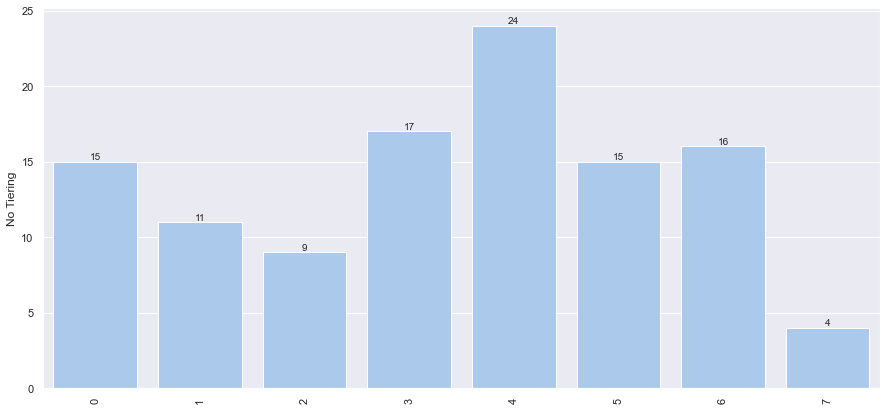

In [10]:
plt.figure(figsize=(15,7))
ax = sns.barplot(data=pv, x=pv.index, y='No Tiering', color='b')
_ = ax.bar_label(ax.containers[0])
_ = plt.xticks(rotation=90)

In [11]:
pv_no_tier_breakdown = oppty[(oppty['Lead Tier'].isna()) & (oppty['Created Date'] >= pd.to_datetime('2022-09-01'))]

pv_no_tier_breakdown = pv_no_tier_breakdown.pivot_table(index=pv_no_tier_breakdown['Created Date'].dt.to_period("W"), columns=['Lead Source'],values ='No Tiering', aggfunc='sum')

In [12]:
pv_no_tier_breakdown

Lead Source,Corp Email Lead,HOTLEAD-Calendly,Social Media Engagement
Created Date,,,
2022-08-29/2022-09-04,5.0,1.0,NaN
2022-09-05/2022-09-11,6.0,8.0,1.0
2022-09-12/2022-09-18,7.0,6.0,3.0
2022-09-19/2022-09-25,NaN,NaN,4.0


#### Conversion Rate per Tier

In [13]:
# closed_oppty = pd.read_csv('raw\sf_export_deal.csv', encoding='latin-1')
# closed_oppty.dropna(subset=['Opportunity ID'], inplace= True)

In [14]:
closed_oppty = oppty[oppty['Stage'].isin(['Deal', 'No Deal'])].reset_index(drop=True)

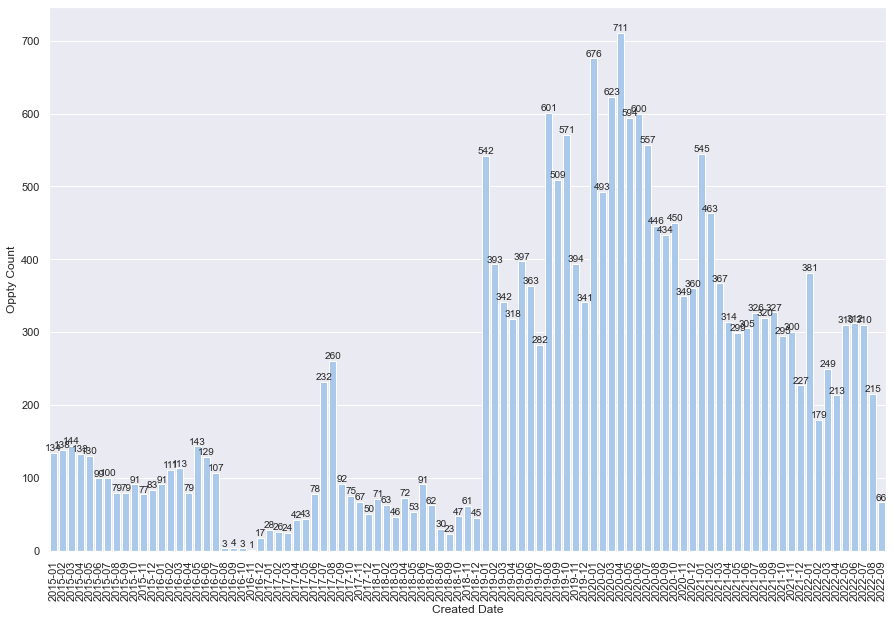

In [15]:
temp_df = closed_oppty.pivot_table(index=closed_oppty['Created Date'].dt.to_period('M'), values='Stage', aggfunc='count').rename(columns={'Stage':'Oppty Count'})


plt.figure(figsize=(15,10))
ax = sns.barplot(data=temp_df, x=temp_df.index, y='Oppty Count', color='b')
_ = ax.bar_label(ax.containers[0])
_ = plt.xticks(rotation=90)

In [16]:
closed_oppty['Lead Tier'].fillna('Not indicated', inplace= True)

In [17]:
tier_conversion = closed_oppty.pivot_table(index='Lead Tier', columns='Stage', values='Created Date', aggfunc='count')[['No Deal','Deal']]

In [18]:
tier_conversion['Conversion Rate'] = (tier_conversion['Deal'] / (tier_conversion['No Deal'] + tier_conversion['Deal'])) * 100

In [19]:
tier_conversion

Stage,No Deal,Deal,Conversion Rate
Lead Tier,,,
Not indicated,3768,117,3.011583
Tier 1,5513,273,4.718286
Tier 2,6232,262,4.034493
Tier 3,1046,42,3.860294
Tier 4,4052,133,3.178017


#### Sales Rep Conversion Rate

##### Lead Source

In [20]:
conversion_pv = closed_oppty.pivot_table(index='Process Tracking For', columns=['Lead Source','Stage'], values='Created Date', aggfunc='count')

In [21]:
temp_dict = {}
for col in conversion_pv.columns.levels[0]:
    temp_dict[col] = conversion_pv.loc[:,(col, 'Deal')] / (conversion_pv.loc[:,(col, 'Deal')] + conversion_pv.loc[:,(col, 'No Deal')])
    # break

In [22]:
sales_rep_conversion_lead_source = pd.DataFrame(temp_dict, index = conversion_pv.index)

<AxesSubplot:xlabel='Process Tracking For'>

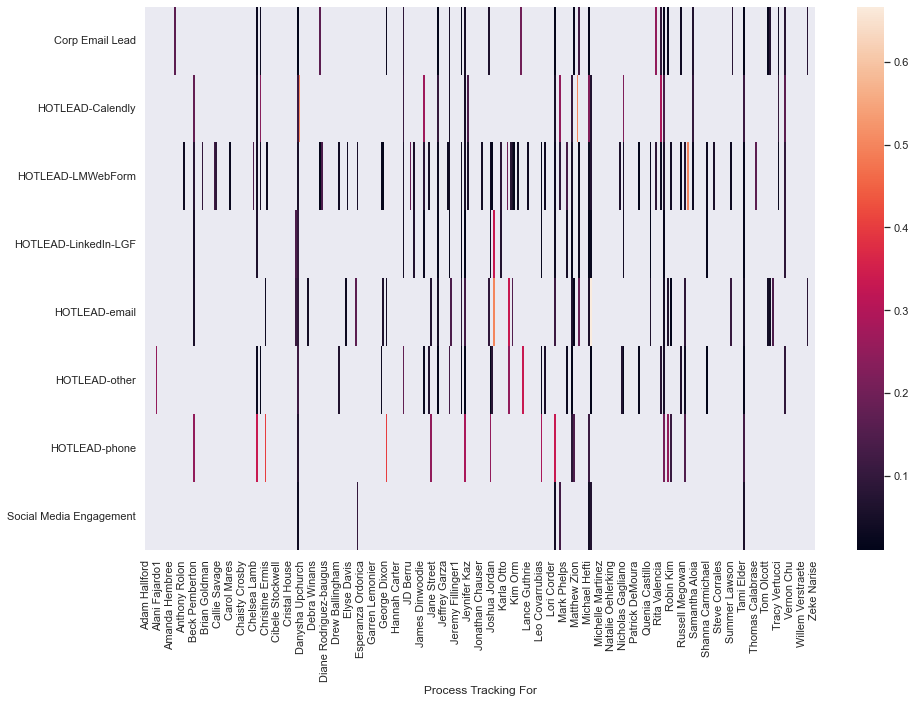

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(sales_rep_conversion_lead_source.T)

#### State

In [24]:
def conversion_rate_converter(dataframe, column_value):
    temp_pv = dataframe.pivot_table(index='Process Tracking For', columns=[column_value,'Stage'], values='Created Date', aggfunc='count')

    temp_dict = {}
    for col in temp_pv.columns.levels[0]:
        if len(temp_pv.loc[:,(col)].columns) == 2:
            temp_dict[col] = temp_pv.loc[:,(col, 'Deal')] / (temp_pv.loc[:,(col, 'Deal')] + temp_pv.loc[:,(col, 'No Deal')])
        else:
            temp_dict[col] = np.nan
            # raise print("There are more than two types of stage values")

    return pd.DataFrame(temp_dict, index = temp_pv.index)


In [25]:
sales_rep_conversion_state = conversion_rate_converter(closed_oppty, 'State')

In [26]:
sales_rep_conversion_tier = conversion_rate_converter(closed_oppty, 'Lead Tier')

In [27]:
conversion_df = pd.concat([sales_rep_conversion_tier,sales_rep_conversion_lead_source,sales_rep_conversion_state], axis=1, join='inner')

In [28]:
conversion_df.reset_index(drop=False, inplace= True)

In [29]:
active_list = '''Brian Goldman
Brigette PinaB
Chelsea Lamb
Cheri Ramos
Dalia Calvert
Dana Sirolli
Daniel Casillas
Erik Martinez
Jack Moller
James Harres
James Susuico
Janine Scott
Jeffrey Garza
Jennifer Depazza
Jerod Arreguini
Jeynifer Kaz
Joshua Jordan
Justin Schwartz
Kurtis Sawyer
Lexi Browne
Malcolm Brown
Marlene Grant-Rodrigues
Melanie Malone
Michael Novi
Michael Piekarski
Michelle Martinez
Natasha Montez
Nicholas Gagliano
Rachelle Westgate
Rob Roback
Robert Proden
Ryan Goida
Shanna Carmichael
Tyra Rymer'''

active_list = active_list.split('\n')

In [47]:
len(active_list)

34

In [30]:
conversion_df['Employment Status'] = conversion_df.apply(lambda x: 'Active' if x['Process Tracking For'] in active_list else 'Inactive', axis= 1)

In [31]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [32]:
X1 = conversion_df.drop(columns=['Process Tracking For', 'Employment Status']).fillna(0).iloc[:,:].values

In [33]:
X1 = preprocessing.normalize(X1)

In [34]:
inertia = []
for n in range(1 , 50):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1325: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


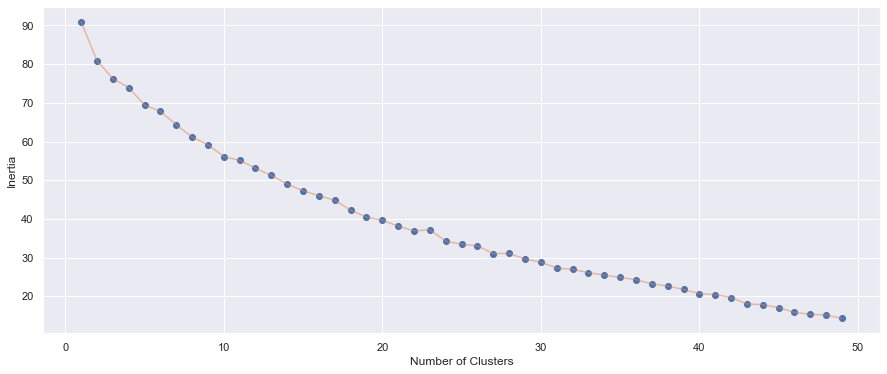

In [35]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 50) , inertia , 'o')
plt.plot(np.arange(1 , 50) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [36]:
algorithm = (KMeans(n_clusters = 30 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
conversion_df['Results'] = algorithm.predict(X1)

In [37]:
def get_similar_performance(dataframe):
    active_list = dataframe.loc[dataframe['Employment Status'] == 'Active','Process Tracking For'].unique()
    temp_dict = {'Salesrep':[], 'Alternative Salesrep':[]}
    for rep in active_list:
        group_filter = dataframe[dataframe['Process Tracking For'] == rep]['Results'].values[0]

        temp_df = dataframe.loc[(dataframe['Results'] == group_filter),:]

        if len(temp_df) < 10:
            temp_dict['Salesrep'].append(rep)
            temp_dict['Alternative Salesrep'].append([value for value in temp_df['Process Tracking For'] if value != rep])

    return pd.DataFrame(temp_dict)

In [38]:
alternative = get_similar_performance(conversion_df)

In [39]:
alternative['Active Rep'] = alternative.apply(lambda x: [value for value in x['Alternative Salesrep'] if value in active_list], axis= 1)
alternative['Inactive Rep'] = alternative.apply(lambda x: [value for value in x['Alternative Salesrep'] if value not in active_list], axis= 1)

In [40]:
alternative

,Salesrep,Alternative Salesrep,Active Rep,Inactive Rep
0,Chelsea Lamb,[Julie Reynolds],[],[Julie Reynolds]
1,Cheri Ramos,[Robert Snezeck],[],[Robert Snezeck]
2,Dana Sirolli,[],[],[]
3,Daniel Casillas,[Melanie Malone],[Melanie Malone],[]
4,Erik Martinez,"[Devanee Lamarra, Janine Scott, Russell Winkler]",[Janine Scott],"[Devanee Lamarra, Russell Winkler]"
5,Jack Moller,"[Andrew Perrine, Anthony Hansen, David Ouellet...",[],"[Andrew Perrine, Anthony Hansen, David Ouellet..."
6,James Harres,"[Howard Martitz, Shanna Carmichael]",[Shanna Carmichael],[Howard Martitz]
7,James Susuico,"[Brooke Abbott, Keith Myers]",[],"[Brooke Abbott, Keith Myers]"
8,Janine Scott,"[Devanee Lamarra, Erik Martinez, Russell Winkler]",[Erik Martinez],"[Devanee Lamarra, Russell Winkler]"
9,Jennifer Depazza,"[Kelly McCaulley, Rob Roback, Robin Kim, Thoma...",[Rob Roback],"[Kelly McCaulley, Robin Kim, Thomas McCourt]"


#### Getting similar deals for training data

In [52]:
training_df = pd.read_csv('raw/sf_export_deal.csv', encoding='latin-1')
training_df = training_df.loc[training_df['Allocation Manager'] != 'Julie Reynolds']

In [53]:
training_df.dropna(subset= ['Opportunity ID'], inplace= True)

In [54]:
for rep in alternative['Salesrep']:
    inactive_list = alternative.loc[alternative['Salesrep'] == rep, 'Inactive Rep'].values[0]

    if len(inactive_list) > 0:
        for inactive_rep in inactive_list:
            training_df.loc[training_df['Allocation Manager'] == inactive_rep, 'Allocation Manager - KNN'] = rep
    # break

In [55]:
training_df[(training_df['Allocation Manager'] == 'Tracy Vertucci') & (training_df['Allocation Manager - KNN'] == 'Beck Pemberton')]

,Deal: ID,Opportunity ID,Opportunity Owner,Order Date,Deal: Deal Name,State [CC1],Membership Fee (After Discount),Down Payment / Initial Payment,Total # of Installments,Amount of Installments - Principal,...,Lead Source Name,Account Name,Phone,Area of Practice 1,Area of Practice 2,Area of Practice 3,Area of Practice 4,Area of Practice 5,Allocation Manager,Allocation Manager - KNN


In [56]:
training_df = training_df.dropna(subset=['Allocation Manager - KNN']).drop(columns=['Allocation Manager']).rename(columns={'Allocation Manager - KNN':'Allocation Manager'})

In [57]:
training_df.reset_index(drop=True, inplace= True)
training_df.to_csv('sf_export_deal_KNN_training_data.csv', index= False)

In [58]:
training_df

,Deal: ID,Opportunity ID,Opportunity Owner,Order Date,Deal: Deal Name,State [CC1],Membership Fee (After Discount),Down Payment / Initial Payment,Total # of Installments,Amount of Installments - Principal,Lead Source,Lead Source Name,Account Name,Phone,Area of Practice 1,Area of Practice 2,Area of Practice 3,Area of Practice 4,Area of Practice 5,Allocation Manager
0,a013200000ni6ZZ,0063200001kr86O,Andrew Perrine,10/15/2015,Gregory Moore - 2015,OH,25020.0,NaN,36,695.0,SELF GEN,NaN,Gregory Moore,(513) 305-9652,Criminal Law,NaN,NaN,NaN,NaN,Jack Moller
1,a013200000oLVPF,0063200001kM8Wg,Andrew Perrine,10/19/2015,Stephanie Bandoske (Formerly Patricia Jay - 2...,TX,11940.0,NaN,12,995.0,SELF GEN,NaN,Patricia A Jay,(817) 261-4333,Family Law,NaN,NaN,NaN,NaN,Jack Moller
2,a013200000o1QRt,0063200001kLLzo,Ben Sandholm,9/16/2015,Matthew Podolsky - Upgrade,FL,11500.0,NaN,16,NaN,UPGRADE,NaN,Matthew B. Podolsky,(813) 418-7060,Family Law,Family Law,NaN,NaN,NaN,Jack Moller
3,a013200000mfJzb,0063200001jwnk8,Andrew Perrine,8/31/2015,Mary Melton - 2015,CA,12600.0,NaN,36,350.0,SELF GEN,NaN,Mary Irene Melton,NaN,"Bankruptcy, Banking and Credit","Wills, Trusts and Estates",NaN,NaN,NaN,Jack Moller
4,a013200000mebtc,0063200001j8lDy,Andrew Perrine,5/28/2015,Cindy Cannon- Deal,CA,15600.0,NaN,12,1300.0,SELF GEN,NaN,Cindy L Cannon,(949) 715-6892,Family Law,NaN,NaN,NaN,NaN,Jack Moller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,a013200000qHvcE,0063200001pQmAu,William Hales,5/16/2017,Thomas Pare 2017,TX,21528.0,NaN,24,875.0,SELF GEN,NaN,THOMAS PARE,(512) 805-6613,Criminal Law,NaN,NaN,NaN,NaN,Joshua Jordan
2211,a013200000pZprL,0063200001oQAlw,William Hales,1/25/2017,Michael Kaliner 2017,PA,7260.0,NaN,12,605.0,SELF GEN,NaN,Michael Kaliner,(215) 230-4250,"Bankruptcy, Banking and Credit",NaN,NaN,NaN,NaN,Joshua Jordan
2212,a013200000paAy3,0063200001pD62N,William Hales,3/15/2017,Karen Ireland-Phillips,OH,6252.0,NaN,12,521.0,SELF GEN,NaN,Karen Ireland-Phillips,(216) 696-5530,Family Law,NaN,NaN,NaN,NaN,Joshua Jordan
2213,a013200000pZrYQ,0063200001oQe3t,William Hales,1/30/2017,Kennedy Koblin 2017,CA,16164.0,NaN,12,1347.0,SELF GEN,NaN,Kennedy Koblin,(925) 298-4808,Family Law,NaN,NaN,NaN,NaN,Joshua Jordan
